In [109]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
)
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

In [110]:
df_final = pd.read_csv("../data/dfgeopoli.csv")
df_final.dropna(subset=['logallexports'], inplace=True)

In [111]:
df_final.columns

Index(['year', 'country_id_o', 'country_o', 'country_id_d', 'country_d',
       'contig', 'distcap', 'dist', 'comlang_off', 'comlang_ethno', 'comrelig',
       'pop_o', 'pop_d', 'gdp_o', 'gdp_d', 'gdpcap_o', 'gdpcap_d', 'fta_wto',
       'tradeflow_comtrade_o', 'tradeflow_comtrade_d', 'tradeflow_imf_o',
       'tradeflow_imf_d', 'IdealPointDistance', 'arms', 'tot_o', 'tot_d',
       'tgdp_ratio_o', 'tgdp_ratio_d', 'avgtradeflow', 'logtradeflow',
       'v2x_polyarchy_o', 'v2x_libdem_o', 'v2x_partipdem_o', 'v2x_delibdem_o',
       'v2x_egaldem_o', 'v2x_polyarchy_d', 'v2x_libdem_d', 'v2x_partipdem_d',
       'v2x_delibdem_d', 'v2x_egaldem_d', 'allexports', 'chemicalexports',
       'consumerexports', 'foodexports', 'machineryexports',
       'manufacturesexports', 'logallexports', 'logchemicalexports',
       'logconsumerexports', 'logfoodexports', 'logmachineryexports',
       'logmanufacturesexports', 'v2x_polyarchy_diff', 'v2x_libdem_diff',
       'v2x_partipdem_diff', 'v2x_delibdem_d

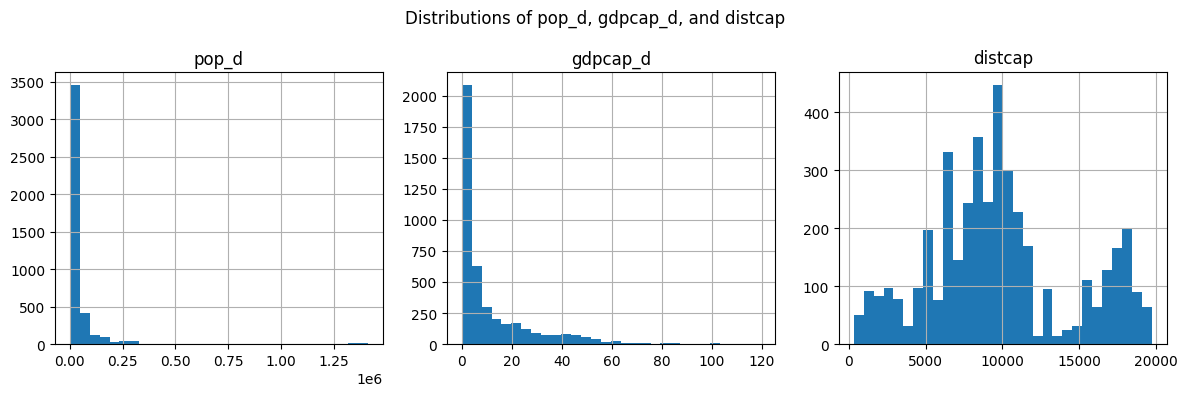

In [112]:
cols = ['pop_d', 'gdpcap_d', 'distcap']

df_final[cols].hist(bins=30, figsize=(12, 4), layout=(1, 3))
plt.suptitle("Distributions of pop_d, gdpcap_d, and distcap")
plt.tight_layout()
plt.show()

In [113]:
# Standardizing non-geopolitical measures

df_final['log_pop_d'] = np.log1p(df_final['pop_d'])
df_final['log_gdpcap_d'] = np.log1p(df_final['gdpcap_d'])
scaler = StandardScaler()
df_final[['log_pop_d', 'log_gdpcap_d', 'distcap']] = scaler.fit_transform(df_final[['log_pop_d', 'log_gdpcap_d', 'distcap']])

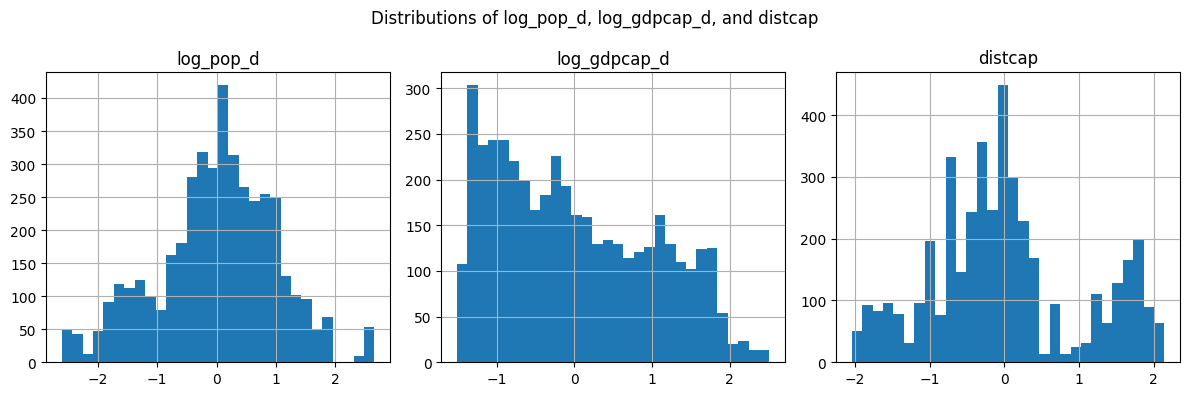

In [114]:
cols = ['log_pop_d', 'log_gdpcap_d', 'distcap']

df_final[cols].hist(bins=30, figsize=(12, 4), layout=(1, 3))
plt.suptitle("Distributions of log_pop_d, log_gdpcap_d, and distcap")
plt.tight_layout()
plt.show()

In [115]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

df_final_2 = df_final.sort_values(by='year')
df_final_2.reset_index(drop=True, inplace=True)

In [116]:
# Modeling
target = 'logallexports'
predictors = ['log_pop_d', 'log_gdpcap_d', 'distcap', 'geopolitical_closeness_index_fa']
X = df_final_2[predictors]
y = df_final_2[target]


# Define TimeSeriesSplit (let's use 5 splits for example)
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=222
)

# Store results for each split
cv_results = {'rmse': [], 'r2': []}
predictions = pd.Series(index=np.arange(len(X)), dtype=float)

# Perform time series cross-validation
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)
    predictions.iloc[test_idx] = y_pred

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    cv_results['rmse'].append(rmse)
    cv_results['r2'].append(r2)

# Calculate average performance across all splits
print(f"Average RMSE: {np.mean(cv_results['rmse']):.4f}")
print(f"Average R²: {np.mean(cv_results['r2']):.4f}")


Average RMSE: 1.4262
Average R²: 0.7535


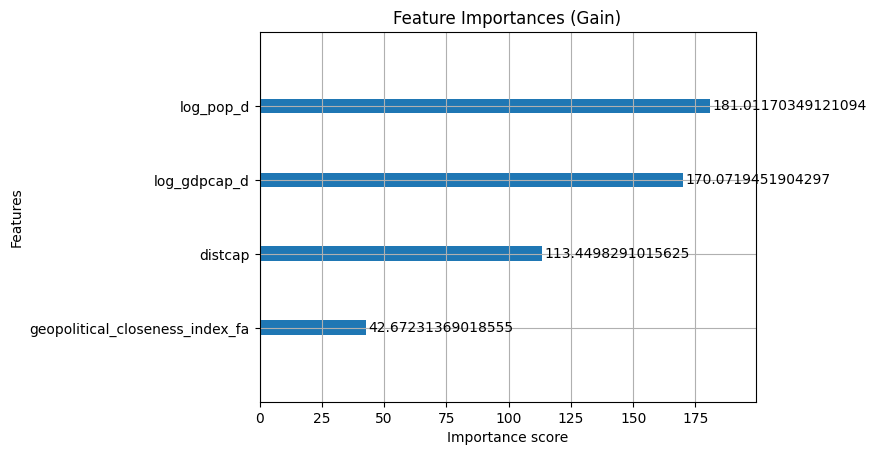

In [117]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Feature Importances (Gain)")
plt.show()

In [118]:
import shap
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

index_pos = list(X_test.columns).index('geopolitical_closeness_index_fa')
feat_pos = X_test['geopolitical_closeness_index_fa']
shap_pos = shap_values[:, index_pos]

corr_pos, p_val_pos = pearsonr(feat_pos, shap_pos)
print(f"Correlation for 'geopolitical_closeness_index_fa': {corr_pos:.4f} (p={p_val_pos:.4f})")

Correlation for 'geopolitical_closeness_index_fa': 0.8475 (p=0.0000)


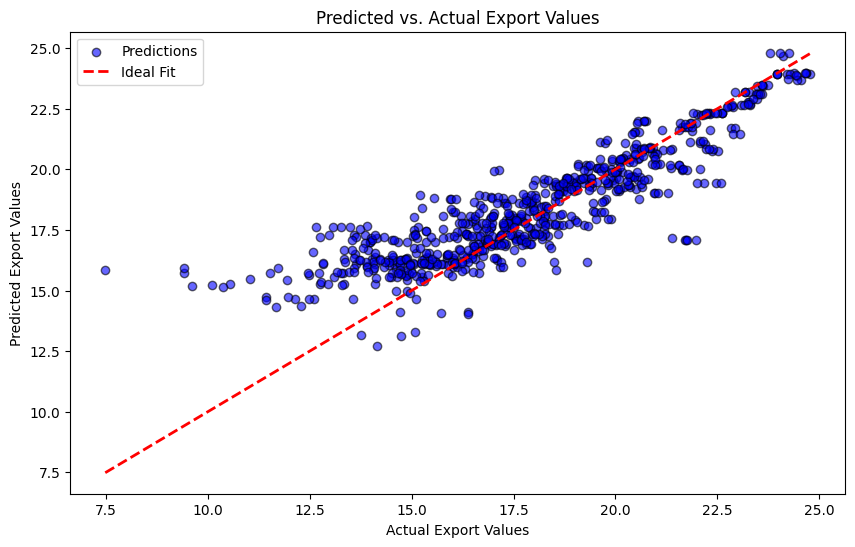

In [119]:
# Predict on the test set using your fitted model (XGBRegressor)
y_pred = model.predict(X_test)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolor='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel("Actual Export Values")
plt.ylabel("Predicted Export Values")
plt.title("Predicted vs. Actual Export Values")
plt.legend()
plt.show()

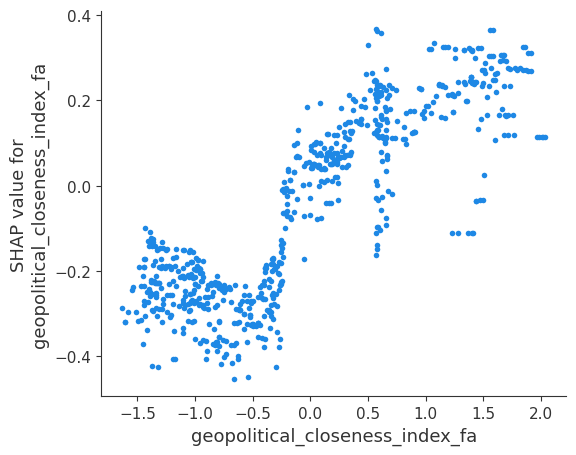

In [120]:
shap.dependence_plot('geopolitical_closeness_index_fa', shap_values, X_test, interaction_index=None)

In [121]:
from scipy.stats import spearmanr

#check correlation between geopolitical_closeness_index_fa and logallexports

corr_spearman, p_value_spearman = spearmanr(
    df_final['geopolitical_closeness_index_fa'],
    df_final['logallexports']
)

print(f"Spearman Correlation: {corr_spearman:.4f} (p-value: {p_value_spearman:.4e})")

Spearman Correlation: 0.3678 (p-value: 6.0705e-137)


In [122]:
df_final_2['predictions'] = np.exp(predictions)

In [123]:
df_final_2

,year,country_id_o,country_o,country_id_d,country_d,contig,distcap,dist,comlang_off,comlang_ethno,...,v2x_libdem_diff,v2x_partipdem_diff,v2x_delibdem_diff,v2x_egaldem_diff,geopolitical_closeness_index_fa,geopolitical_closeness_index_pca,geopolitical_closeness_index_pls,log_pop_d,log_gdpcap_d,predictions
0,1989,SGP,Singapore,AFG,Afghanistan,0,-1.001795,5147.0,0,0,...,0.239,0.063,0.268,0.202,-0.072925,0.252650,-0.903242,0.106182,-1.388242,NaN
1,1989,SGP,Singapore,EGY,Egypt,0,-0.329280,8270.0,0,1,...,0.112,0.002,0.131,0.195,-0.871992,1.190658,-1.803314,0.946123,-1.105065,NaN
2,1989,SGP,Singapore,JAM,Jamaica,0,1.738010,17870.0,1,1,...,0.147,0.262,0.102,0.110,-0.707050,0.831961,-1.019351,-0.711757,-0.672526,NaN
3,1989,SGP,Singapore,JOR,Jordan,0,-0.417355,7861.0,0,1,...,0.110,0.025,0.165,0.143,-0.800921,1.142469,-1.498555,-0.578917,-0.827136,NaN
4,1989,SGP,Singapore,ECU,Ecuador,0,2.141131,19607.0,0,0,...,0.191,0.387,0.154,0.055,-0.355824,-0.223934,-1.091887,0.039744,-0.818595,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,2020,SGP,Singapore,KAZ,Kazakhstan,0,-0.751352,5363.0,0,0,...,0.207,0.024,0.204,0.151,-0.394697,0.287570,-1.765609,0.377167,0.405297,1.241126e+08
4268,2020,SGP,Singapore,VNM.2,Vietnam,0,-1.637702,1092.0,0,0,...,0.325,0.102,0.344,0.352,0.579677,0.107505,1.448087,1.244995,-0.280136,7.277253e+09
4269,2020,SGP,Singapore,JPN,Japan,0,-0.966694,5310.0,0,0,...,0.423,0.439,0.405,0.415,1.164691,-0.582137,2.751577,1.382103,1.594868,1.551274e+10
4270,2020,SGP,Singapore,LBR,Liberia,0,0.630502,12727.0,1,1,...,0.094,0.245,0.161,0.046,-0.862951,0.887363,-0.904793,-0.313470,-1.165131,2.608403e+07


In [145]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

def plot_country(country):
    # Filter the DataFrame for the selected country
    df_country = df_final_2[df_final_2['country_d'] == country]
    
    # Create the plot
    plt.figure(figsize=(12,6))
    plt.plot(df_country['year'], df_country['allexports'], label='Actual Exports', marker='o')
    plt.plot(df_country['year'], df_country['predictions'], label='Predicted Exports', marker='o')
    plt.xlabel('Year')
    plt.ylabel('Exports')
    plt.title(f'Actual vs Predicted Exports for {country}')
    plt.legend()
    plt.show()

In [146]:
country_options = df_final_2['country_d'].unique()

In [147]:
widgets.interact(plot_country, country=widgets.Dropdown(options=country_options, description='Country'))

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Egypt', 'Jamaica', 'Jordan', 'E…

<function __main__.plot_country(country)>